In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

In [2]:
import tensorflow
print (tensorflow.__version__)

2.4.0


In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!unzip /content/gdrive/MyDrive/GAN_datasets/selfie2anime.zip -d /

Streaming output truncated to the last 5000 lines.
  inflating: /trainA/female_26059.jpg  
  inflating: /trainA/female_26076.jpg  
  inflating: /trainA/female_26092.jpg  
  inflating: /trainA/female_26125.jpg  
  inflating: /trainA/female_26139.jpg  
  inflating: /trainA/female_26145.jpg  
  inflating: /trainA/female_26149.jpg  
  inflating: /trainA/female_26157.jpg  
  inflating: /trainA/female_26167.jpg  
  inflating: /trainA/female_26181.jpg  
  inflating: /trainA/female_26190.jpg  
  inflating: /trainA/female_26195.jpg  
  inflating: /trainA/female_26219.jpg  
  inflating: /trainA/female_26223.jpg  
  inflating: /trainA/female_26226.jpg  
  inflating: /trainA/female_26227.jpg  
  inflating: /trainA/female_26231.jpg  
  inflating: /trainA/female_26239.jpg  
  inflating: /trainA/female_26241.jpg  
  inflating: /trainA/female_26247.jpg  
  inflating: /trainA/female_26273.jpg  
  inflating: /trainA/female_26278.jpg  
  inflating: /trainA/female_26279.jpg  
  inflating: /trainA/female_2

In [5]:
!ls /

bin	 dev   lib32  opt   sbin   tensorflow-1.15.2  tools   var
boot	 etc   lib64  proc  srv    testA	      trainA
content  home  media  root  swift  testB	      trainB
datalab  lib   mnt    run   sys    tmp		      usr


In [6]:
import glob
#path = "/Users/k15/Downloads/selfie2anime/"
path='/'
faces = glob.glob(path + 'trainA/*.jpg')
animes = glob.glob(path + 'trainB/*.jpg')
faces_test = glob.glob(path + 'testA/*.jpg')
animes_test = glob.glob(path + 'testB/*.jpg')

In [7]:
len(faces), len(animes), len(faces_test), len(animes_test)

(3400, 3400, 100, 100)

In [8]:
import cv2
for file in animes[:10]:
    img = cv2.imread(file)
    print (img.shape)

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


Faces


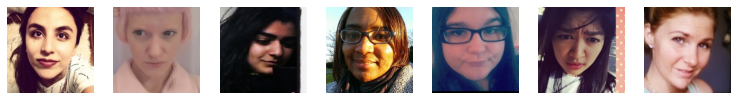

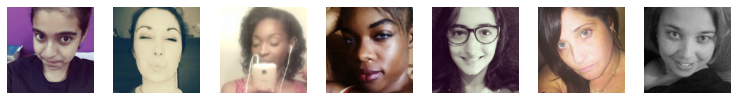

--------------------------------------------------------------------------------
Animes


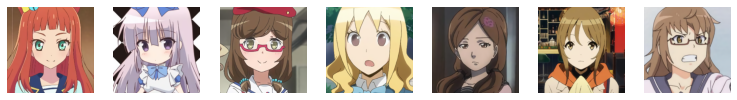

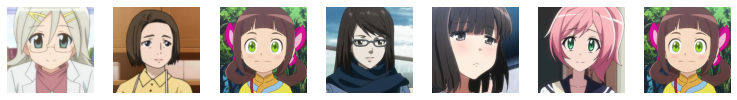

In [9]:
print ("Faces")
for k in range(2):
    plt.figure(figsize=(13, 13))
    for j in range(7):
        file = np.random.choice(faces)
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(770 + 1 + j)
        plt.imshow(img)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

print ("-"*80)
print ("Animes")
for k in range(2):
    plt.figure(figsize=(13, 13))
    for j in range(7):
        file = np.random.choice(animes)
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(770 + 1 + j)
        plt.imshow(img)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

# Generator Model (U-Net Like)

In [10]:
import tensorflow_addons as tfa

In [11]:
def encoder_layer(input_layer, filters, bn=True):
    x = tensorflow.keras.layers.Conv2D(filters, kernel_size=(4,4), strides=(2,2), padding='same')(input_layer)
    x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
    if bn:
        #x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
        x = tfa.layers.InstanceNormalization()(x)
    return x

def decoder_layer(input_layer, skip_input, filters):
    #x = tensorflow.keras.layers.UpSampling2D(size=2)(input_layer)
    x = tensorflow.keras.layers.Conv2DTranspose(filters, kernel_size=(4,4), strides=(2,2), padding='same')(input_layer)
    x = tensorflow.keras.layers.Activation('relu')(x)
    #x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
    x = tfa.layers.InstanceNormalization()(x)
    x = tensorflow.keras.layers.Concatenate()([x, skip_input])
    return x

In [12]:
source_image_A = tensorflow.keras.layers.Input(shape=(256, 256, 3))
source_image_B = tensorflow.keras.layers.Input(shape=(256, 256, 3))

def make_generator():
    source_image = tensorflow.keras.layers.Input(shape=(256, 256, 3))

    e1 = encoder_layer(source_image, 32, bn=False)
    e2 = encoder_layer(e1, 64)
    e3 = encoder_layer(e2, 128)
    e4 = encoder_layer(e3, 256)
    e5 = encoder_layer(e4, 256)
    e6 = encoder_layer(e5, 256)
    e7 = encoder_layer(e6, 256)

    bottle_neck = tensorflow.keras.layers.Conv2D(512, (4,4), strides=(2,2), padding='same')(e7)
    b = tensorflow.keras.layers.Activation('relu')(bottle_neck)

    d1 = decoder_layer(b, e7, 256)
    d2 = decoder_layer(d1, e6, 256)
    d3 = decoder_layer(d2, e5, 256)
    d4 = decoder_layer(d3, e4, 256)
    d5 = decoder_layer(d4, e3, 256)
    d6 = decoder_layer(d5, e2, 64)
    d7 = decoder_layer(d6, e1, 32)

    decoded = tensorflow.keras.layers.Conv2DTranspose(3, kernel_size=(4,4), strides=(2,2), padding='same')(d7)
    translated_image = tensorflow.keras.layers.Activation('tanh')(decoded)
    return source_image, translated_image, bottle_neck

source_image, translated_image, bottle_neck = make_generator()
generator_network_AB = tensorflow.keras.models.Model(inputs=source_image, outputs=[translated_image,bottle_neck])

source_image, translated_image, bottle_neck = make_generator()
generator_network_BA = tensorflow.keras.models.Model(inputs=source_image, outputs=[translated_image,bottle_neck])

print (generator_network_AB.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 1568        input_3[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 128, 128, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 64)   32832       leaky_re_lu[0][0]                
______________________________________________________________________________________________

# Discriminator Network

In [13]:
def my_conv_layer(input_layer, filters, bn=True):
    x = tensorflow.keras.layers.Conv2D(filters, kernel_size=(4,4), strides=(2,2), padding='same')(input_layer)
    x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
    if bn:
        #x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
        x = tfa.layers.InstanceNormalization()(x)
    return x

In [14]:
 def make_discriminator():
    target_image_input = tensorflow.keras.layers.Input(shape=(256, 256, 3))

    x = my_conv_layer(target_image_input, 64, bn=False)
    x = my_conv_layer(x, 128)
    x = my_conv_layer(x, 256)
    #x = my_conv_layer(x, 512)
    x = my_conv_layer(x, 512)

    patch_features = tensorflow.keras.layers.Conv2D(1, kernel_size=(4,4), strides=(1,1), padding='same')(x)
    return target_image_input, patch_features


target_image_input, patch_features = make_discriminator()
discriminator_network_A = tensorflow.keras.models.Model(inputs=target_image_input, outputs=patch_features)

target_image_input, patch_features = make_discriminator()
discriminator_network_B = tensorflow.keras.models.Model(inputs=target_image_input, outputs=patch_features)

print (discriminator_network_A.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 128, 128, 64)      3136      
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 64, 64, 128)       131200    
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 64, 64, 128)       0         
_________________________________________________________________
instance_normalization_26 (I (None, 64, 64, 128)       256       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 32, 32, 256)       5245

In [15]:
adam_optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_network_A.compile(loss='mse', optimizer=adam_optimizer, metrics=['accuracy'])
discriminator_network_B.compile(loss='mse', optimizer=adam_optimizer, metrics=['accuracy'])

# Customized-Cycle-GAN

In [16]:
# Domain Transfer
fake_B, fake_latent_AB = generator_network_AB(source_image_A)
fake_A, fake_latent_BA = generator_network_BA(source_image_B)

# Restoring original Domain
get_back_A, _ = generator_network_BA(fake_B)
get_back_B, _ = generator_network_AB(fake_A)

# Get back Identical/Same Image
get_same_A, _ = generator_network_BA(source_image_A)
get_same_B, _ = generator_network_AB(source_image_B)
  
discriminator_network_A.trainable=False
discriminator_network_B.trainable=False

# Tell Real vs Fake, for a given domain
verify_A = discriminator_network_A(fake_A)
verify_B = discriminator_network_B(fake_B)

custom_cycle_gan = tensorflow.keras.models.Model(inputs = [source_image_A, source_image_B],\
    outputs = [verify_A, verify_B, get_back_A, get_back_B, get_same_A, get_same_B, fake_latent_AB, fake_latent_BA])
custom_cycle_gan.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
model_1 (Functional)            [(None, 256, 256, 3) 16888451    input_2[0][0]                    
                                                                 model[0][0]                      
                                                                 input_1[0][0]                    
____________________________________________________________________________________________

# Compiling Models

In [17]:
custom_cycle_gan.compile(loss=['mse', 'mse', 'mae', 'mae', 'mae', 'mae', 'mae', 'mae'], \
                          loss_weights=[1, 1, 10, 10, 10, 10, 1000, 1000], optimizer=adam_optimizer)

# Define Data Generators

In [18]:
def faces_to_animes(faces, generator_network):
    generated_samples, _ = generator_network.predict_on_batch(faces)
    return generated_samples

def animes_to_faces(animes, generator_network):
    generated_samples, _ = generator_network.predict_on_batch(animes)
    return generated_samples

def get_face_samples(batch_size):
    random_files = np.random.choice(faces, size=batch_size)
    images = []
    for file in random_files:
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append((img-127.5)/127.5)
    face_images = np.array(images)
    return face_images

def get_anime_samples(batch_size):
    random_files = np.random.choice(animes, size=batch_size)
    images = []
    for file in random_files:
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append((img-127.5)/127.5)
    anime_images = np.array(images)
    return anime_images

def show_generator_results_faces_to_animes(generator_network_AB, generator_network_BA):
    images = []
    for j in range(7):
        file = np.random.choice(faces)
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)

    print ('Input Face Images')
    plt.figure(figsize=(13, 13))
    for j, img in enumerate(images):
        plt.subplot(770 + 1 + j)
        plt.imshow(img)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

    print ('Translated (Face -> Anime) Images')
    translated = []
    plt.figure(figsize=(13, 13))
    for j, img in enumerate(images):
        img = (img-127.5)/127.5
        output = faces_to_animes(np.array([img]), generator_network_AB)[0]
        translated.append(output)
        output = (output+1.0)/2.0
        plt.subplot(770 + 1 + j)
        plt.imshow(output)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

    print ('Translated reverse (Fake Anime -> Fake Faces)')
    plt.figure(figsize=(13, 13))
    for j, img in enumerate(translated):
        output = animes_to_faces(np.array([img]), generator_network_BA)[0]
        output = (output+1.0)/2.0
        plt.subplot(770 + 1 + j)
        plt.imshow(output)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

def show_generator_results_animes_to_faces(generator_network_AB, generator_network_BA):
    images = []
    for j in range(7):
        file = np.random.choice(animes)
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)

    print ('Input Anime Images')
    plt.figure(figsize=(13, 13))
    for j, img in enumerate(images):
        plt.subplot(770 + 1 + j)
        plt.imshow(img)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

    print ('Translated (Anime -> Face) Images')
    translated = []
    plt.figure(figsize=(13, 13))
    for j, img in enumerate(images):
        img = (img-127.5)/127.5
        output = animes_to_faces(np.array([img]), generator_network_BA)[0]
        translated.append(output)
        output = (output+1.0)/2.0
        plt.subplot(770 + 1 + j)
        plt.imshow(output)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

    print ('Translated reverse (Fake Face -> Fake Anime)')
    plt.figure(figsize=(13, 13))
    for j, img in enumerate(translated):
        output = faces_to_animes(np.array([img]), generator_network_AB)[0]
        output = (output+1.0)/2.0
        plt.subplot(770 + 1 + j)
        plt.imshow(output)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

# Training GAN

In [19]:
len(faces), len(animes)

(3400, 3400)

Input Face Images


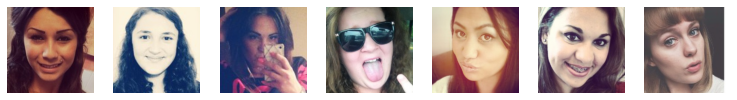

Translated (Face -> Anime) Images


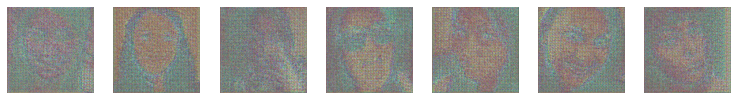

In [ ]:
epochs = 500
batch_size = 1
steps = 3400

for i in range(0, epochs):
    for j in range(steps):  
        if j%200 == 0:
            show_generator_results_faces_to_animes(generator_network_AB, generator_network_BA)
            print ("-"*100)
            show_generator_results_animes_to_faces(generator_network_AB, generator_network_BA)

        # A == Face
        # B == Anime
        domain_A_images = get_face_samples(batch_size)
        domain_B_images = get_anime_samples(batch_size)

        fake_patch = np.zeros((batch_size, 16, 16, 1))
        real_patch = np.ones((batch_size, 16, 16, 1))
        
        fake_B_images, _ = generator_network_AB(domain_A_images)
        fake_A_images, _ = generator_network_BA(domain_B_images)
        
        # Updating Discriminator A weights
        discriminator_network_A.trainable=True
        discriminator_network_B.trainable=False
        loss_d_real_A = discriminator_network_A.train_on_batch(domain_A_images, real_patch)
        loss_d_fake_A = discriminator_network_A.train_on_batch(fake_A_images, fake_patch)
        
        loss_d_A = np.add(loss_d_real_A, loss_d_fake_A)/2.0
        
        # Updating Discriminator B weights
        discriminator_network_B.trainable=True
        discriminator_network_A.trainable=False
        loss_d_real_B = discriminator_network_B.train_on_batch(domain_B_images, real_patch)
        loss_d_fake_B = discriminator_network_B.train_on_batch(fake_B_images, fake_patch)
        
        loss_d_B = np.add(loss_d_real_B, loss_d_fake_B)/2.0
        
        # Make the Discriminator belive that these are real samples and calculate loss to train the generator
        
        discriminator_network_A.trainable=False
        discriminator_network_B.trainable=False
        
        _, latent_AA= generator_network_BA(domain_A_images)
        _, latent_BB = generator_network_AB(domain_B_images)
        
        # Updating Generator weights
        loss_g = custom_cycle_gan.train_on_batch([domain_A_images, domain_B_images],\
                        [real_patch, real_patch, domain_A_images, domain_B_images, domain_A_images, domain_B_images,\
                           latent_BB, latent_AA])
        
        if j%50 == 0:
            print ("Epoch:%.0f, Step:%.0f, DA-Loss:%.3f, DA-Acc:%.3f, DB-Loss:%.3f, DB-Acc:%.3f, G-Loss:%.3f"\
                   %(i,j,loss_d_A[0],loss_d_A[1]*100,loss_d_B[0],loss_d_B[1]*100,loss_g[0]))
            